# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

In [28]:
# reduce data set to columns race, call
df = data[['race', 'call']]
df.info()

# create an array that contains only values from call data and converts to int for boolean uses
white = df[df.race=='w'].call.values.astype(int)
black = df[df.race=='b'].call.values.astype(int)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 2 columns):
race    4870 non-null object
call    4870 non-null float32
dtypes: float32(1), object(1)
memory usage: 95.1+ KB


## 4. Write a story describing the statistical significance in the context or the original problem.

## 1. What test is appropriate for this problem?
* Does CLT apply

We'll be using an A/B approach comparing the mean call-back between two variables (white/black race association). Since we're comparing the means between two variables we'll use a two-sample z-test.

CLT can apply
* Population: People applying for jobs (with white/black-race associated catagories).
* Sample: 
    * 4870 observations
        * 2435 White caragories, 235 call-backs (1, True)
        * 2435 Black catagories, 157 call-backs (1, True)

In [7]:
# number of callbacks for black-sounding names
print(sum(black), 'total callbacks for black-sounding names')

# number of callbacks for white-sounding names
print(sum(white), 'total callbacks for white-sounding names')

157 total callbacks for black-sounding names
235 total callbacks for white-sounding names


In [8]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays"""
    return abs(np.mean(data_1) - np.mean(data_2))

black_mean = np.mean(black)
white_mean = np.mean(white)
print('The mean call back rate for white sounding names is: ', white_mean)
print('The mean call back rate for black sounding names is: ', black_mean)

mean_diff = diff_of_means(white, black)
print('The difference between the two mean call back rates is: ', mean_diff)

The mean call back rate for white sounding names is:  0.09650924024640657
The mean call back rate for black sounding names is:  0.06447638603696099
The difference between the two mean call back rates is:  0.032032854209445585


In [27]:
'''
This function will allow us to take our data and increase the number of our observations.
'''
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size): # Can this be done by list comprehension
        bs_replicates[i] = func(np.random.choice(data, len(data)))

    return bs_replicates

**Graphing Probability Density Functions on white and black mean call-back rates**

The standard error of the mean (SEM) of: 
The original white call data is: 0.003070897766516499
Our white bootstrapped data is: 0.003062148527142928

The SEM of the original black call data is: 0.00253107552474999
and SEM of our black bootstrapped data is: 0.0025405998557859145


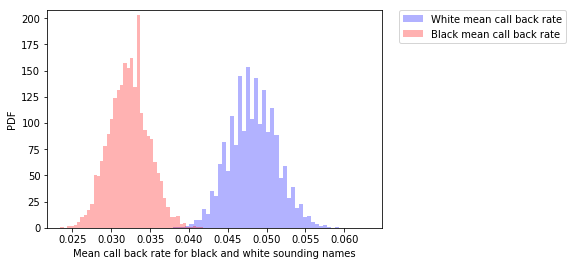

In the white PDF there is a 95% chance a data point would fall between [0.04250513 0.05441478]
The difference between the 2.5%, 50%, 97.5% percentiles are:  [0.00575345] [0.0061562]
In the black PDF there is a 95% chance a data point would fall between [0.02731006 0.03716632]
The difference between the 2.5%, 50%, 97.5% percentiles are:  [0.00494634] [0.00490992]

This shows that we have symmetry, normal distribution


In [26]:
# Take 100,000 bootstrap replicates of the mean: bs_replicates
w_replicates = draw_bs_reps(white, np.mean, 10000)
b_replicates = draw_bs_reps(black, np.mean, 10000)

# Compute the standard error of mean
w_sem = np.std(white) / np.sqrt(len(white))
b_sem = np.std(black) / np.sqrt(len(black))

# Compute standard deviation of bootstrap replicates
w_std = np.std(w_replicates)
b_std = np.std(b_replicates)

print('The standard error of the mean (SEM) of: ')
print('The original white call data is: ' + str(w_sem))
print('Our white bootstrapped data is: ' + str(w_std))
print('\nThe SEM of the original black call data is: ' + str(b_sem))
print('and SEM of our black bootstrapped data is: ' + str(b_std))

# Make a histogram of the results
_ = plt.hist(w_replicates, bins=50, normed=True, alpha=.3, label = 'White mean call back rate', color='blue')
_ = plt.hist(b_replicates, bins=50, normed=True, alpha=.3, label = 'Black mean call back rate', color='red')
plt.xlabel('Mean call back rate for black and white sounding names')
plt.ylabel('PDF')
plt.margins(.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Show the plot
plt.show()

print('In the white PDF there is a 95% chance a data point would fall between', np.percentile(w_replicates, [2.5, 97.5]))
print('The difference between the 2.5%, 50%, 97.5% percentiles are: ',\
     np.mean(w_replicates) - np.percentile(w_replicates, [2.5]),\
     np.percentile(w_replicates, [97.5]) - np.mean(w_replicates))
print('In the black PDF there is a 95% chance a data point would fall between', np.percentile(b_replicates, [2.5, 97.5]))
print('The difference between the 2.5%, 50%, 97.5% percentiles are: ',\
     np.mean(b_replicates) - np.percentile(b_replicates, [2.5]),\
     np.percentile(b_replicates, [97.5]) - np.mean(b_replicates))

print('\nThis shows that we have symmetry, normal distribution')

**CLT _(does not)_ applies to this because of _(reason)_**

Randomization Condition: The data must be sampled randomly. Is one of the good sampling methodologies discussed in the chapter “Sampling and Data” being used?

Independence Assumption: The sample values must be independent of each other. This means that the occurrence of one event has no influence on the next event. Usually, if we know that people or items were selected randomly we can assume that the independence assumption is met.

10% Condition: When the sample is drawn without replacement (usually the case), the sample size, n, should be no more than 10% of the population.

Sample Size Assumption: The sample size must be sufficiently large. Although the Central Limit Theorem tells us that we can use a Normal model to think about the behavior of sample means when the sample size is large enough, it does not tell us how large that should be. If the population is very skewed, you will need a pretty large sample size to use the CLT, however if the population is unimodal and symmetric, even small samples are acceptable. So think about your sample size in terms of what you know about the population and decide whether the sample is large enough. In general a sample size of 30 is considered sufficient if the sample is unimodal (and meets the 10% condition).

## 2. What are the null and alternate hypothesis?

$H_0$: The mean of black sounding names ($\mu$) is the same as white sounding names ($\mu_0$), $\mu$ = $\mu_0$. That black sounding names receive the same call-back rate as white sounding names $\alpha$ = 0.05

$H_A$: The call-back rate, mean, of the different sounding names is not the same. $\mu\neq\mu_0$.

### 3. Compute margin of error, confidence interval, and p-value. 
* Try using bootstrapping 
* and the frequentist statistical approaches.

Standard Error = Square root $\Sigma$ standard deviation of variable squared divided by n of variable

The critical value for 95% confidence is 1.96, for 99% is 2.54.

Margin of Error:

In [50]:
# Standard Error
stan_err = np.sqrt((np.std(white)**2) / len(white) + (np.std(black)**2) / len(black))
print(f'{stan_err:.10f}')

moe = 1.96 * stan_err # Margin of Error
print(f'{moe:.10f}')

0.0077833706
0.0152554063


In [34]:
# Confidence interval
print(mean_diff - moe, mean_diff + moe)
print(mean_diff + np.array([-1,1]) * moe)

0.016777447859559147 0.047288260559332024
[0.01677745 0.04728826]


To produce our z-test results, we'll use the following formula:
![alt text](https://www.cliffsnotes.com/assets/267207.png "Two sample formula")

In [49]:
numerator = diff_of_means(white, black) #x1bar - x2bar - delta (0)
z = numerator / stan_err # Standard Error == denominator
pval = stats.norm.cdf(-z) * 2
print('Z score: ', f'{z:.5f}')
print('P-value: ', f'{pval:.7f}')

Z score:  4.11555
P-value:  0.0000386


Third Item:

In [48]:
# Calculating length
n_w = len(white)
n_b = len(black)

prop_w = np.sum(white) / len(white) # Mean of white
prop_b = np.sum(black) / len(black) # Mean of black

prop_diff = prop_w - prop_b # Difference of means
phat = (np.sum(white) + np.sum(black)) / (len(white) + len(black)) 

z = prop_diff / np.sqrt(phat * (1 - phat) * ((1 / n_w) + (1 / n_b)))
pval = stats.norm.cdf(-z) * 2
print('Z score: ', f'{z:.5f}')
print('P-value: ', f'{pval:.7f}')

moe = 1.96 * np.sqrt(phat * (1 - phat) * ((1 / n_w) + (1 / n_b)))
ci = prop_diff + np.array([-1, 1]) * moe
print('Margin of Error: ', f'{moe:.5f}')
print("Confidence interval: {}".format(ci)) 

#From https://dscareercommunity.springboard.com/t/80k54y/eda-mini-projects

Z score:  4.10841
P-value:  0.0000398
Margin of Error:  0.01528
Confidence interval: [0.01675094 0.04731477]


In [47]:
'''
SUM / LEN = MEAN
phat = (sum1 + sum 2) / (len1 + len2)
phat == np.mean(total)
however phat != np.mean(total)
'''
print(prop_w)
print(np.mean(white))

total1 = white + black
total2 = np.concatenate([white,black])
print(phat)
print(np.mean(total2))

0.09650924024640657
0.09650924024640657
0.08049281314168377
0.08049281314168377


<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

## 4. Write a story describing the statistical significance in the context or the original problem.

## 5. Does your analysis mean that race/name is the most important factor in callback success? 
* Why or why not? 
    * If not, how would you amend your analysis?

No, it does not mean that race-name association is the most important factor in call-back successs. The analysis
demonstrates that race-name association -- _ceteris paribus_ -- has statistically probability to affect call-back success.

Our p-value does allow us to say that race-name association conclusion is free from type 1 errors, that we're not falsely rejecting our null hypothesis.
Type 2 errors may be present in our data. We don't know where the sample is taken from, which period, or if the sample accounts for the full spectrum of population variability.

To amend the analysis, we'd want to look into how other factors affect call-back rates. Education, work experience, sex, computer and special skills, military, and volunteer are a few of the factors that should be looked at. After comparing each of their call-back rates the results may determine, education or work experience to be larger factors in call-back rates.
Another item would be to understand the story of the sample. To address any possible type 2 errors. In other words the sampling scheme.

If, exluding race-name association, we could determine that there was no statistical probablity difference in call-back rates between those variables, we could determine that race-name association to be the most important factor_